In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
def generate_room_points(num_points=1024, center=(0,0), radius=5.0):
    points, labels = [], []
    
    n_floor = num_points // 2
    x = np.random.uniform(center[0]-radius/2, center[0]+radius/2, n_floor)
    y = np.random.uniform(center[1]-radius/2, center[1]+radius/2, n_floor)
    z = np.full(n_floor, 0.0)
    rgb = np.random.rand(n_floor, 3) * 0.3 + 0.7
    pts = np.column_stack([x, y, z, rgb])
    points.append(pts)
    labels.append(np.full(n_floor, 0))

    # Стена
    n_wall = num_points - n_floor
    angles = np.random.rand(n_wall) * 2 * np.pi
    r = radius + np.random.randn(n_wall) * 0.1
    x = center[0] + r * np.cos(angles)
    y = center[1] + r * np.sin(angles)
    z = np.random.rand(n_wall) * 2.5
    rgb = np.random.rand(n_wall, 3) * 0.3
    pts = np.column_stack([x, y, z, rgb])
    points.append(pts)
    labels.append(np.full(n_wall, 1))

    return np.vstack(points).astype(np.float32), np.concatenate(labels).astype(np.int64)

blocks, labels = [], []
for i in range(50):
    pts, lbls = generate_room_points(num_points=4096, center=(i%3, i//3))
    blocks.append(pts)
    labels.append(lbls)

blocks = np.stack(blocks)   # (50, 4096, 6)
labels = np.stack(labels)   # (50, 4096)

print(" Сгенерировано 50 блоков (2 класса: 0=floor, 1=wall).")

 Сгенерировано 50 блоков (2 класса: 0=floor, 1=wall).


In [ ]:
class PointCloudDataset(Dataset):
    def __init__(self, points, labels):
        self.points = points
        self.labels = labels

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return torch.from_numpy(self.points[idx]), torch.from_numpy(self.labels[idx])

dataset = PointCloudDataset(blocks, labels)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=0)

print(f"Train: {len(train_ds)} блоков, Val: {len(val_ds)} блоков")
print(f"Форма батча: {next(iter(train_loader))[0].shape} → (B=2, N=4096, 6)")

Train: 35 блоков, Val: 15 блоков
Форма батча: torch.Size([2, 4096, 6]) → (B=2, N=4096, 6)


In [ ]:
def square_distance(src, dst):
    return torch.sum((src[:, :, None, :] - dst[:, None, :, :]) ** 2, dim=-1)

def farthest_point_sample(xyz, npoint):
    device = xyz.device
    B, N, _ = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long, device=device)
    distance = torch.ones(B, N, device=device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long, device=device)
    batch_indices = torch.arange(B, dtype=torch.long, device=device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids

def index_points(points, idx):
    raw_shape = idx.shape
    idx = idx.reshape(raw_shape[0], -1)
    res = torch.gather(points, 1, idx.unsqueeze(-1).expand(-1, -1, points.size(-1)))
    return res.reshape(*raw_shape, -1)

def query_ball_point(radius, nsample, xyz, new_xyz):
    device = xyz.device
    B, N, _ = xyz.shape
    S = new_xyz.shape[1]
    K = nsample
    group_idx = torch.arange(N, dtype=torch.long, device=device).view(1, 1, N).repeat(B, S, 1)
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :K]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat(1, 1, K)
    mask = group_idx == N
    group_idx[mask] = group_first[mask]
    return group_idx

class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp):
        super().__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel + 3
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel

    def forward(self, xyz, points):
        B, N, _ = xyz.shape
        S = self.npoint

        fps_idx = farthest_point_sample(xyz, S)
        new_xyz = index_points(xyz, fps_idx)
        idx = query_ball_point(self.radius, self.nsample, xyz, new_xyz)
        grouped_xyz = index_points(xyz, idx)
        grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, 3)

        if points is not None:
            grouped_points = index_points(points, idx)
            new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1)
        else:
            new_points = grouped_xyz_norm

        new_points = new_points.permute(0, 3, 2, 1)
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))
        new_points = torch.max(new_points, 2)[0]
        new_points = new_points.permute(0, 2, 1)
        return new_xyz, new_points

class PointNetFeaturePropagation(nn.Module):
    def __init__(self, in_channel, mlp):
        super().__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel

    def forward(self, xyz1, xyz2, points1, points2):
        B, N, _ = xyz1.shape
        _, S, _ = xyz2.shape

        if S == 1:
            interpolated_points = points2.repeat(1, N, 1)
        else:
            dists = square_distance(xyz1, xyz2)
            dists, idx = dists.sort(dim=-1)
            dists, idx = dists[:, :, :3], idx[:, :, :3]
            dist_recip = 1.0 / (dists + 1e-8)
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm
            interpolated_points = torch.sum(index_points(points2, idx) * weight.unsqueeze(-1), dim=2)

        if points1 is not None:
            new_points = torch.cat([points1, interpolated_points], dim=-1)
        else:
            new_points = interpolated_points

        new_points = new_points.permute(0, 2, 1)
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))
        return new_points.permute(0, 2, 1)

class MiniPointNet2Seg(nn.Module):
    def __init__(self, num_classes=2):  # 2 класса в демо
        super().__init__()
        self.sa1 = PointNetSetAbstraction(
            npoint=512, radius=0.2, nsample=32, in_channel=3, mlp=[32, 64]
        )
        self.fp1 = PointNetFeaturePropagation(in_channel=64 + 3, mlp=[128, 128])
        self.conv1 = nn.Conv1d(128, 128, 1)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(128, num_classes, 1)

    def forward(self, xyzrgb):
        xyz = xyzrgb[:, :, :3]
        rgb = xyzrgb[:, :, 3:]
        new_xyz, feat = self.sa1(xyz, rgb)
        feat_up = self.fp1(xyz, new_xyz, rgb, feat)
        x = feat_up.permute(0, 2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.drop1(x)
        x = self.conv2(x)
        return x.permute(0, 2, 1)  # (B, N, C)

In [ ]:
device = torch.device("cpu")
model = MiniPointNet2Seg(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Логи
train_losses, val_losses = [], []

for epoch in range(1, 101):
    model.train()
    train_loss = 0.0
    for points, labels in train_loader:
        points, labels = points.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(points)
        loss = criterion(out.reshape(-1, 2), labels.reshape(-1))  
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for points, labels in val_loader:
            points, labels = points.to(device), labels.to(device)
            out = model(points)
            loss = criterion(out.reshape(-1, 2), labels.reshape(-1))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    scheduler.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch:2d} | Train: {train_losses[-1]:.4f} | Val: {val_losses[-1]:.4f}")



Epoch  5 | Train: 0.0026 | Val: 0.0015
Epoch 10 | Train: 0.0010 | Val: 0.0005
Epoch 15 | Train: 0.0007 | Val: 0.0004
Epoch 20 | Train: 0.0005 | Val: 0.0003
Epoch 25 | Train: 0.0004 | Val: 0.0002
Epoch 30 | Train: 0.0004 | Val: 0.0002
Epoch 35 | Train: 0.0004 | Val: 0.0002
Epoch 40 | Train: 0.0003 | Val: 0.0002
Epoch 45 | Train: 0.0003 | Val: 0.0002
Epoch 50 | Train: 0.0003 | Val: 0.0001
Epoch 55 | Train: 0.0003 | Val: 0.0001
Epoch 60 | Train: 0.0003 | Val: 0.0001
Epoch 65 | Train: 0.0003 | Val: 0.0001
Epoch 70 | Train: 0.0003 | Val: 0.0001
Epoch 75 | Train: 0.0003 | Val: 0.0001
Epoch 80 | Train: 0.0003 | Val: 0.0001
Epoch 85 | Train: 0.0003 | Val: 0.0001
Epoch 90 | Train: 0.0003 | Val: 0.0001
Epoch 95 | Train: 0.0003 | Val: 0.0001
Epoch 100 | Train: 0.0003 | Val: 0.0001


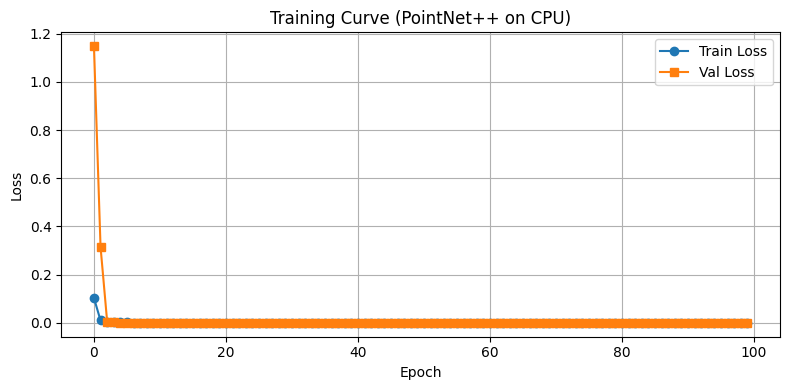

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Curve (PointNet++ on CPU)')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()